In [45]:
# Set up autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import Libraries

In [46]:
# Natural Language Libraries
import nltk
from nltk.corpus import opinion_lexicon

# Scikit-Learn
from sklearn.linear_model import SGDClassifier
# Data Handling
import pandas as pd

import json
from joblib import load

# Custom Modules
from text_processing.pre_processing import *
from features.feature_extraction import *
from glove.glove_controller import *
from evaluation import *

### Constants and Supplementary Data

In [47]:
# Random Seed
RANDOM_STATE = 123

# Positive and Negative words lexicon
positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

# Sarcasm Classifier Load
sarcasm_model = load("../../data/sarcasm_model.pkl")
sarcasm_vec = load("../../data/dict_vectorizer.pkl")

# Load profanity list
with open('../../data/profanity.txt', 'r') as f:
    profanity_words = [s.strip() for s in f.readlines()]

# Load slang list
with open('../../data/slang.txt', 'r') as f:
    slang_words = [s.strip() for s in f.readlines()]

# Set punctuation list
punct_list = ['!','#','@']

# Load emoji sentiment
with open("../../data/emoji_polarity.json", "r", encoding="utf-8") as f:
    emoji_json = json.load(f)

# Load emoticon sentiment
with open("../../data/emoticon_polarity.json", "r", encoding="utf-8") as f:
    emoticon_json = json.load(f)
combined_sentiment = {**emoji_json, **emoticon_json}

# Define GloVe variables
glove_path = r"C:\Users\eggle\Downloads\glove.twitter.27B\glove.twitter.27B.200d.txt"
EMBED_DIM = 200 

### Load Datasets

In [48]:
# df_train = pd.read_csv('../../data/twitter_sentiment_train.csv')
# df_test  = pd.read_csv('../../data/twitter_sentiment_test.csv')

# # Shuffle train set
# df_train = df_train.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

In [49]:
from sklearn.model_selection import train_test_split

# Load both datasets
df_train = pd.read_csv('../../data/twitter_sentiment_train.csv')
df_test  = pd.read_csv('../../data/twitter_sentiment_test.csv')

# Concatenate both datasets into one
df_combined = pd.concat([df_train, df_test], ignore_index=True)

# Split into 80% training and 20% testing
df_train, df_test = train_test_split(
    df_combined,
    test_size=0.2,           # 20% for testing
    random_state=RANDOM_STATE,
    stratify=df_combined['label']  # Ensures balanced class distribution in both splits
)

### Apply preprocessing to Datasets

In [50]:
# Apply preprocessing to the datasets
clean_tokens_train = [preprocessing_text(t) for t in df_train['text']]
clean_tokens_test = [preprocessing_text(t) for t in df_test['text']]
clean_text_train = [' '.join(tokens) for tokens in clean_tokens_train]
clean_text_test = [' '.join(tokens) for tokens in clean_tokens_test]

### Feature Extraction

In [51]:
# Define Custom functions
feature_functions = [
    lambda text: count_specified_punctuations(text, punct_list),
    lambda text: count_profanity_words(text, profanity_words),
    lambda text: count_slang_words(text, slang_words), 
    count_all_capital_tokens, 
    count_not,
    count_sad_emoticons,
    count_happy_emoticons,
    count_elongated_words,
    lambda text: count_positive_words(text, positive_words),
    lambda text: count_negative_words(text, negative_words),
    uppercase_ratio,
    count_pos_tags,
    count_named_entities,
    lambda text: get_sentiment_and_subjectivity(text, combined_sentiment),
    lambda text: predict_sarcasm(text, sarcasm_vec, sarcasm_model),
    tweet_word_count,
    tweet_avg_word_length,
]

# Process datasets with TF-IDF
# tfidf_train, tfidf_test, vectorizer = tfidf_features(clean_text_train, clean_text_test, (1,2), 3100)

# Load GloVe model
glove_vectors = load_glove(glove_path, EMBED_DIM, use_cache=True)

Loading GloVe from cache: glove\glove.pkl
Loaded 1193514 word vectors from cache


In [52]:
# Create glove feature matrices
glove_train = np.vstack([tweet_to_glove_vector(t, glove_vectors, EMBED_DIM) for t in tqdm(clean_text_train, desc="Embedding train")])
glove_test  = np.vstack([tweet_to_glove_vector(t, glove_vectors, EMBED_DIM) for t in tqdm(clean_text_test, desc="Embedding test")])

glove_train = pd.DataFrame(glove_train, columns=[f"glv_{i}" for i in range(EMBED_DIM)])
glove_test  = pd.DataFrame(glove_test,  columns=[f"glv_{i}" for i in range(EMBED_DIM)])

Embedding test: 100%|██████████| 4107/4107 [00:00<00:00, 86058.60it/s]


#### Concatenate all features together (TF-IDF + GloVe + Custom Features)

In [ ]:
X_train = df_train[['text']].copy()
X_test  = df_test[['text']].copy()

# Extract Custom Features
for func in tqdm(feature_functions, desc="Computing custom features"):
    results = X_train['text'].apply(lambda x: func(str(x))).tolist()
    X_train = pd.concat([X_train, pd.DataFrame(results)], axis=1)
    results = X_test['text'].apply(lambda x: func(str(x))).tolist()
    X_test = pd.concat([X_test, pd.DataFrame(results)], axis=1)

# Drop column name
X_train_custom = X_train.drop(columns=['text'])
X_test_custom  = X_test.drop(columns=['text'])

# Concat Custom Features with GloVE embeddings
X_train_final = pd.concat([glove_train.reset_index(drop=True), X_train_custom.reset_index(drop=True)], axis=1)
X_test_final  = pd.concat([glove_test.reset_index(drop=True),  X_test_custom.reset_index(drop=True)], axis=1)

X_train_final.columns = X_train_final.columns.astype(str)
X_test_final.columns  = X_test_final.columns.astype(str)
y_train = df_train['label']
y_test  = df_test['label']

Computing custom features:  71%|███████   | 12/17 [02:14<01:58, 23.80s/it]

### Train and Evaluate Logistic Regression


=== Model Evaluation ===
Accuracy: 0.8726957617772176
              precision    recall  f1-score   support

    negative       0.88      0.93      0.90      3972
    positive       0.87      0.78      0.82      2375

    accuracy                           0.87      6347
   macro avg       0.87      0.85      0.86      6347
weighted avg       0.87      0.87      0.87      6347



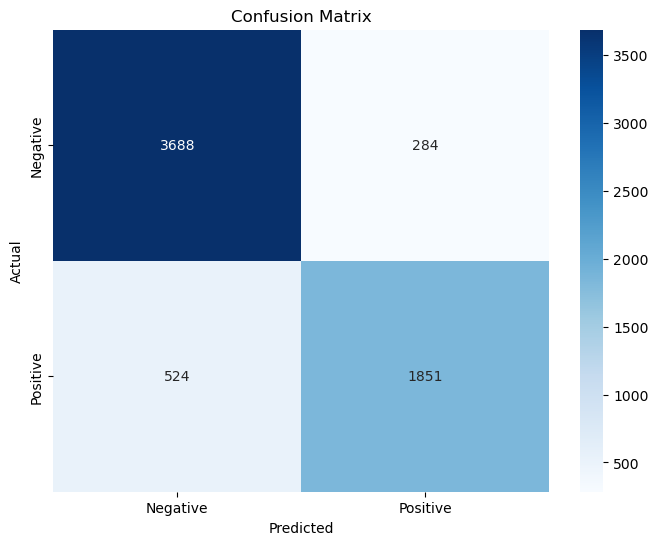

In [ ]:
# HyperParameter Initialization
best_params = {
    'alpha' : 0.0006492,
    'eta0' : 0.03049,
    'learning_rate' : 'adaptive'
}

# Initialize Model
final_model = SGDClassifier(
    loss='log_loss',
    alpha=best_params['alpha'],
    eta0=best_params['eta0'],
    learning_rate=best_params['learning_rate'],
    max_iter=5000,
    random_state=RANDOM_STATE,
    tol=1e-3
)

# Train
final_model.fit(X_train_final, y_train)

# Get predictions
y_pred = final_model.predict(X_test_final)

# Print report
evaluate_model(y_test, y_pred)

# Generate confusion matrix
plot_confusion_matrix(y_test, y_pred)


### Feature Evaluation and Missclassified Tweets


Top 205 Most Important Features:
                 feature  importance
208  negative_word_count    0.060316
257   positive_sentiment    0.042200
258   negative_sentiment    0.026136
109              glv_109    0.020453
139              glv_139    0.019826
..                   ...         ...
195              glv_195    0.002432
21                glv_21    0.002423
1                  glv_1    0.002411
57                glv_57    0.002407
173              glv_173    0.002383

[205 rows x 2 columns]


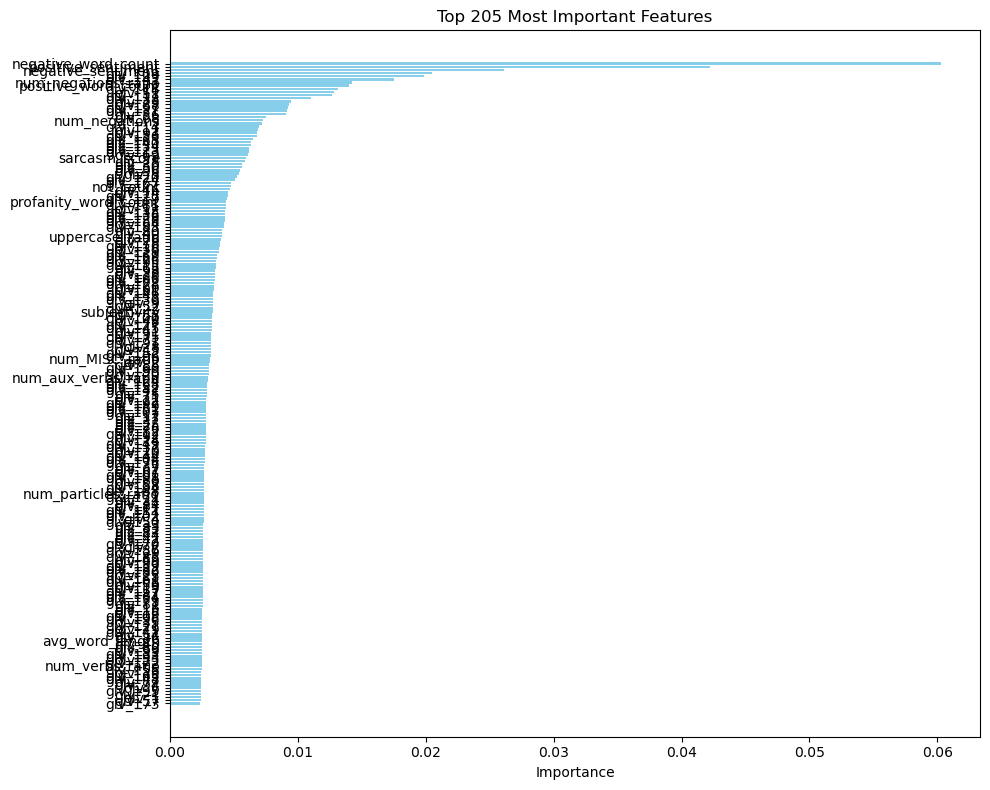


Total Misclassified: 808 out of 6347 (12.73%)

Example 1:
  Text: @user Wow,first Hugo Chavez and now Fidel Castro. Danny Glover, Michael Moore, Oliver Stone, and Sean Penn are running out of heroes.
  True Label: Negative
  Predicted: Positive
  ----------------------------------------------------------------------------

Example 2:
  Text: @user Going to see #FantasticBeasts this afternoon. Mom is a Potter fanatic. My niece was, but she's kinda growing out of it.
  True Label: Positive
  Predicted: Negative
  ----------------------------------------------------------------------------

Example 3:
  Text: @user Yes, white supremacists are America's greatest problem ever.  OMG.  GET REAL.  #GOAWAY
  True Label: Negative
  Predicted: Positive
  ----------------------------------------------------------------------------

Example 4:
  Text: #NoDAPL #CorporateGreed #corporations are #evil especially the media #corporations #tpp #TrumpTrain #bravo #cnn #foxnews #soulless #wrong 😣
  True L

In [ ]:
# Plot in bar chart feature importance
plot_feature_importance(
    get_feature_importance(X_train_final, y_train, 25, RANDOM_STATE), 
    25
)

# Print missclassified tweets
analyze_misclassifications(y_test, y_pred, df_test)